# Sistema RAG com IA Generativa

## O que é RAG (Retrieval-Augmented Generation)?

É uma técnica que **combina dois mundos**:

- **Bancos vetoriais**: Para **busca de contexto relevante** (como o *Pinecone, ChromaDB, QDrant, FAISS, etc*)
- **LLM**: Para **geração de texto** com IA a partir do contexto

Resolve um dos principais problemas de LLMs: **"alucinação"**, ou seja, gerar respostas sem base real.

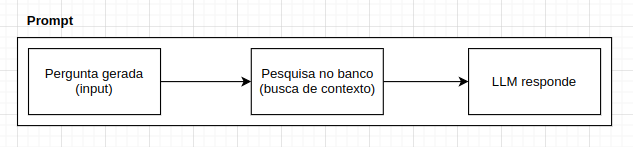


### Onde podemos utilizar a arquitetura RAG?

Podemos popular nosso banco vetorial com dados personalizados para cada caso, como por exemplo:

- **Educação**: Responder dúvidas com base em **materiais de aula**, **apostilas**, **livros didáticos**, etc;

- **Jurídico**: Consultar jurisprudência, leis e pareceres, **gerar respostas com base em contexto legal**;

- **Empresas**: Criar **assistentes internos** com **base em documentos, manuais, políticas, relatórios**, etc;

- **Ciência e saúde**: Buscar e **explicar artigos científicos**, estudos médicos, **laudos**, **protocolos**, etc;

- **Tecnologia**: Suporte usando **base de conhecimento de produtos, documentações, códigos, repositórios**, etc;


### Por que usar RAG?

- Garante respostas com **base em fontes reais**
- Diminui o risco de "alucinações"
- Permite uso de **documentos personalizados**
- Evita depender 100% da memória do modelo (*dos dados que aquele determinado modelo foi treinado*)
- **Não exige re-treinamento do modelo**, apenas boas fontes e bons prompts
- Permite que LLMs respondam com base em dados que eles não "conhecem" (*dados que não foram treinados*)
- Torna sistemas mais confiáveis, transparentes e atualizáveis

## O que é Banco Vetorial?

- Banco de dados especializado no armazenamento e busca de vetores;
- Os vetores são representações numéricas (embeddings) de textos, imagens, áudio, etc;
- Permite busca por similaridade, em vez de buscas exatas por palavras ou valores;
- Quando o usuário faz uma pergunta, ela também é vetorizada (transformada em embedding);
- O sistema realiza uma busca por similaridade vetorial usando o algoritmo KNN (K-Nearest Neighbors);
- O parâmetro K define quantos vetores mais próximos da query serão retornados;

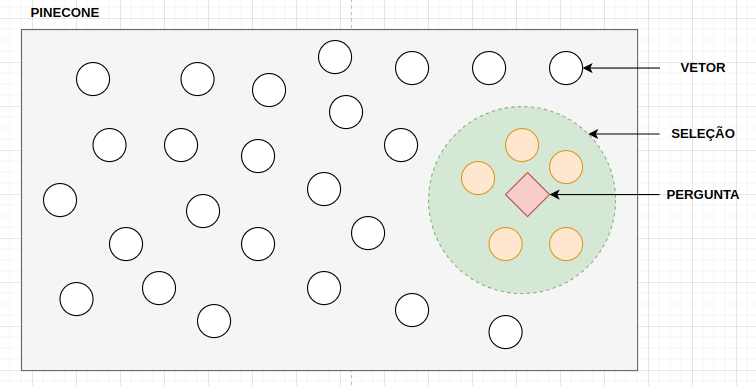

In [ ]:
!pip install sentence-transformers pinecone --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')


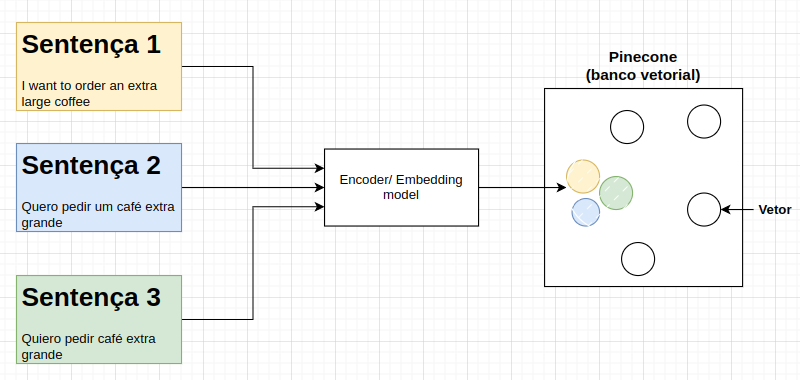

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = [
  "I want to order an extra large coffee",            # Sentença 1
  "Quero pedir um café extra grande",                 # Sentença 2
  "Quiero pedir café extra grande"                    # Sentença 3
]

embeddings = model.encode(sentences, convert_to_tensor=True)
similarities = util.cos_sim(embeddings, embeddings)

**Podemos reparar que:**

- Vetores estão próximos entre si no espaço vetorial;
- O conteúdo semântico é similar (mesmo em idiomas diferentes);

In [ ]:
import pandas as pd

df_sim = pd.DataFrame(similarities.numpy(), index=sentences, columns=sentences)
df_sim.round(2)

,I want to order an extra large coffee,Quero pedir um café extra grande,Quiero pedir café extra grande
I want to order an extra large coffee,1.00,0.42,0.44
Quero pedir um café extra grande,0.42,1.00,0.80
Quiero pedir café extra grande,0.44,0.80,1.00


In [ ]:
embeddings # temos 3 embeddings (matriz 1 x 3)

tensor([[-0.0045, -0.0117,  0.0414,  ..., -0.0031,  0.0073, -0.0703],
        [ 0.0134, -0.0331, -0.0131,  ...,  0.0480, -0.0182, -0.0577],
        [-0.0308, -0.0006, -0.0123,  ...,  0.0269,  0.0254, -0.0418]])

In [ ]:
print(f"Dimensões dos vetores: {embeddings[0].shape[0]}")
print(f"Exibição parcial do vetor 0 (de 384 posições): {embeddings[0][:10]}")

Dimensões dos vetores: 384
Exibição parcial do vetor 0 (de 384 posições): tensor([-0.0045, -0.0117,  0.0414,  0.0581, -0.0184, -0.0148, -0.0582,  0.0645,
         0.0132, -0.0090])


## O que vamos fazer?

Este projeto consiste em construir um sistema inteligente de **perguntas e respostas sobre notícias reais**.

Combinamos três componentes:

- **Scraping de notícias** do portal O Globo;
- **Busca semântica** com **embeddings e Pinecone**;
- **Geração de texto** com **LLM (LLaMA via Ollama em Cloud Run)**;

O resultado é um sistema que entende o que foi perguntado, **busca trechos relevantes em notícias reais** e **gera uma resposta com base no contexto**.

## Visão Geral do Pipeline

---
Abaixo está o fluxo completo de como os dados são processados e usados no sistema:

1. **Scraper**: coleta notícias do sitemap do O Globo.
2. **Splitter**: divide cada matéria em pedaços menores (chunks).
3. **Embedder**: gera vetores numéricos para cada chunk com modelo da HuggingFace.
4. **Pinecone Index**: armazena os chunks vetoriais.

Depois que o sistema está indexado:

5. **User Query**: o usuário envia uma pergunta.
6. **Retriever**: busca os chunks mais relevantes no Pinecone.
7. **Prompt Builder**: monta um prompt com os trechos encontrados.
8. **LLM (Ollama)**: responde com base no contexto real.
9. **Resposta**: o usuário recebe uma resposta gerada e contextualizada.

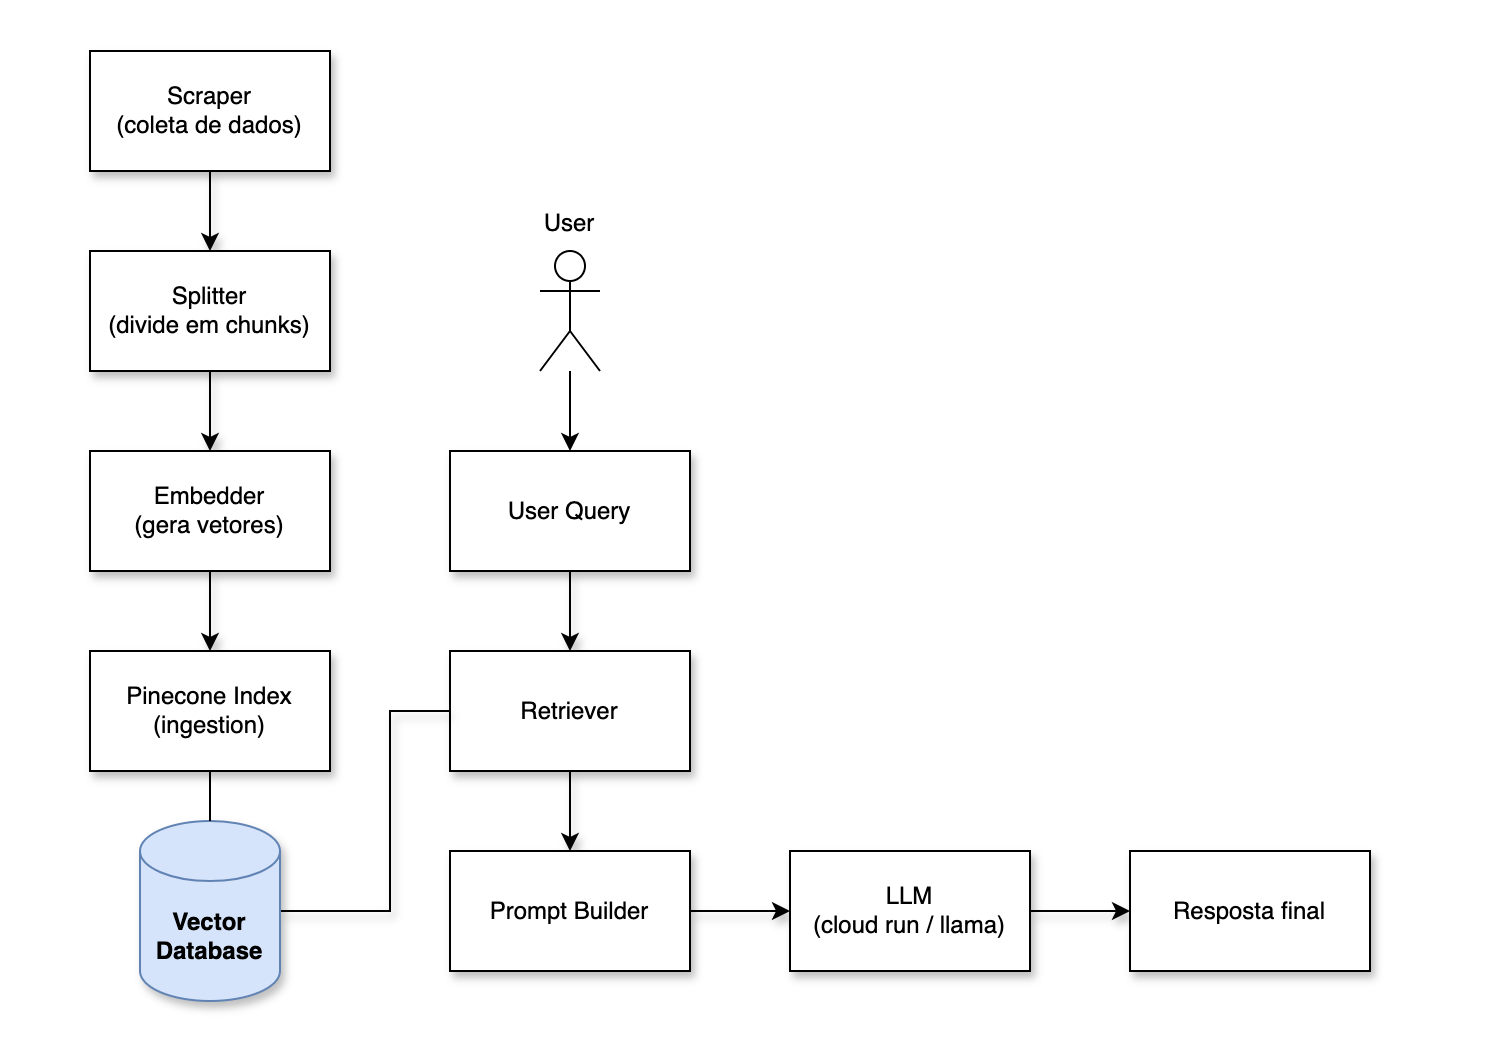

## 2. Coleta e Extração de Notícias (Scraping)

Nesta etapa, acessamos o **sitemap de notícias do O Globo** para coletar os metadados (URL, título, data) e em seguida extraímos o conteúdo completo de cada matéria.

Usamos `BeautifulSoup` para realizar o scraping diretamente do HTML das páginas de notícia

### scraper.py

In [ ]:
import requests
import xml.etree.ElementTree as ET

from bs4 import BeautifulSoup
from typing import List, Dict

SITEMAP_URL = "https://oglobo.globo.com/sitemap/oglobo/news.xml"

In [ ]:
def fetch_sitemap_xml(url: str) -> str:
    """Faz o download do XML do sitemap."""
    response = requests.get(url)
    response.raise_for_status()
    return response.text

In [ ]:
def parse_sitemap(xml_content: str) -> List[Dict]:
    """Extrai URLs, datas e títulos do sitemap XML."""
    ns = {
        "news": "http://www.google.com/schemas/sitemap-news/0.9",
        "image": "http://www.google.com/schemas/sitemap-image/1.1",
        "": "http://www.sitemaps.org/schemas/sitemap/0.9",
    }

    root = ET.fromstring(xml_content)
    articles = []

    for url in root.findall("url", ns):
        loc = url.find("loc", ns).text
        title = url.find("news:news/news:title", ns).text
        publication_date = url.find("news:news/news:publication_date", ns).text
        image_url = url.find("image:image/image:loc", ns)
        image_url = image_url.text if image_url is not None else None

        articles.append({
            "url": loc,
            "title": title,
            "date": publication_date,
            "image_url": image_url,
        })

    return articles

In [ ]:
def scrape_article_text(url: str) -> str:
    """Extrai o corpo principal da matéria do O Globo."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        article = soup.find("article")
        if article:
            return article.get_text(separator="\n", strip=True)

        # fallback (usado em algumas páginas)
        content_div = soup.find("div", {"class": "content-text"})
        if content_div:
            return content_div.get_text(separator="\n", strip=True)

        return None

    except Exception as e:
        print(f"[ERRO] ao fazer scraping de {url}: {e}")
        return None

In [ ]:
def get_articles_from_sitemap() -> List[Dict]:
    """Executa o pipeline completo de scraping a partir do sitemap."""
    print("Baixando sitemap...")
    xml_content = fetch_sitemap_xml(SITEMAP_URL)
    raw_articles = parse_sitemap(xml_content)

    print(f"{len(raw_articles)} matérias encontradas no sitemap.")

    articles_with_content = []

    for article in raw_articles:
        print(f"Extraindo conteúdo: {article['url']}")
        content = scrape_article_text(article["url"])
        if content:
            articles_with_content.append({
                **article,
                "content": content
            })
        if len(articles_with_content) == 3: break # REMOVER CASO QUEIRA INSERIR MAIS DADOS: VISANDO DEMONSTRAÇÃO

    print(f"\n\n{len(articles_with_content)} matérias com conteúdo extraído.")
    return articles_with_content

### Execução do scraper.py

In [ ]:
# Coletando as matérias do sitemap atual
articles = get_articles_from_sitemap()

In [ ]:
# Exibindo as 3 primeiras URLs
for a in articles[:3]:
    print(f"Título : {a['title']}")
    print(f"Data   : {a['date']}")
    print(f"URL    : {a['url']}")
    print(f"---")

Baixando sitemap...
720 matérias encontradas no sitemap.
Extraindo conteúdo: https://oglobo.globo.com/saude/noticia/2025/05/17/e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml
Extraindo conteúdo: https://oglobo.globo.com/blogs/fumus-boni-iuris/post/2025/05/a-ofensiva-da-camara-vista-pelo-stf.ghtml
Extraindo conteúdo: https://oglobo.globo.com/cultura/noticia/2025/05/17/cecilia-morre-em-vale-tudo-ativista-e-baleada-sofre-grave-acidente-e-fica-em-coma-saiba-o-que-acontece.ghtml


3 matérias com conteúdo extraído.
Título : É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência
Data   : 2025-05-17T15:08:02.991000+00:00
URL    : https://oglobo.globo.com/saude/noticia/2025/05/17/e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml
---
Título : A ofensiva da Câmara vista pelo STF
Data   : 2025-05-17T15:00:22.095000+00:00
URL    : http

In [ ]:
import textwrap

amostra = articles[0]

print(f"Título: {amostra['title']}")
print(f"Data: {amostra['date']}")
print(f"URL: {amostra['url']}\n")
print("Trecho do conteúdo extraído:\n")
print(textwrap.shorten(amostra["content"], width=1000, placeholder="..."))

Título: É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência
Data: 2025-05-17T15:08:02.991000+00:00
URL: https://oglobo.globo.com/saude/noticia/2025/05/17/e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml

Trecho do conteúdo extraído:

Já está bem estabelecido que dormir pouco pode aumentar o risco de doenças, incluindo demência. Mas um novo estudo indica que dormir demais pode ser igualmente prejudicial. Vivi para Contar: 'O morcego não só me mordeu. Ele me 'esfaqueou': tive que pegar empréstimo no banco' , diz jornalista Veja também: ‘Estamos vivendo uma epidemia de arritmias cardíacas’, alerta cardiologista Eduardo Saad De acordo com pesquisadores do Centro de Ciências da Saúde da Universidade do Texas, nos EUA, dormir em média nove horas por noite pode estimular o envelhecimento cerebral, levando a problemas de memória na vida adulta. O estudo descobriu que essa quantidade de

### O que fizemos até aqui?

Acessamos o **sitemap XML** do O Globo (https://oglobo.globo.com/sitemap/oglobo/news.xml) e extraímos os campos:
  - `url` → Link da notícia
  - `title` → Título
  - `date` → Data de publicação
  - `content` → Conteúdo extraído do HTML da página

---

Agora vamos:

1. Dividir em partes menores (chunks);
2. Transformar em vetores semânticos (embeddings);
3. Inserir no banco vetorial Pinecone;

## 3. Divisão em Chunks

**LLMs têm um limite de "janela de contexto"**, não conseguem lidar com textos muito longos de forma eficiente.

Para resolver isso:
- Dividimos cada matéria em **vários trechos menores (chunks)** de até ~200 palavras;
- Vinculamos cada chunk ao conteúdo extraido, incluindo sua respectiva posição;
- Para cada chunk, adicionamos metadados para melhor enriquecimento;

Assim, cada pedaço pode ser processado individualmente e armazenado no banco vetorial de forma mais eficiente

### utils.py

In [ ]:
import re

from typing import List, Dict

In [ ]:
def split_text(text: str, max_words: int = 200) -> List[str]:
    """Divide um texto em chunks com até 'max_words' palavras, preservando frases."""
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []

    for sentence in sentences:
        words = sum(len(s.split()) for s in current_chunk + [sentence])
        if words <= max_words:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [ ]:
def split_articles_into_chunks(articles: List[Dict], max_words: int = 200) -> List[Dict]:
    """Transforma artigos inteiros em múltiplos chunks prontos para embedding"""
    chunked_articles = []

    for article in articles:
        chunks = split_text(article["content"], max_words)
        for idx, chunk in enumerate(chunks):
            chunked_articles.append({
                "chunk_id": f"{article['url'].split('/')[-1]}_chunk_{idx}",
                "article_url": article["url"],
                "title": article["title"],
                "date": article["date"],
                "image_url": article.get("image_url", ""),
                "content": chunk,
                "position": idx
            })

    return chunked_articles

### Execução do utils.py

In [ ]:
import json

# Exemplo: Dividindo a primeira notícia em contextos menores
amostra_artigo = articles[0:1]
chunks = split_articles_into_chunks(amostra_artigo, max_words=200)

print(json.dumps(amostra_artigo[0], indent=2, ensure_ascii=False))
print(f"\n\nTotal de palavras: {len(amostra_artigo[0]['content'].split())}")
print(f"Número de chunks gerados: {len(chunks)}\n")

{
  "url": "https://oglobo.globo.com/saude/noticia/2025/05/17/e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml",
  "title": "É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência",
  "date": "2025-05-17T15:08:02.991000+00:00",
  "image_url": "https://s2-oglobo.glbimg.com/SAMGRdpuWn0WQZ6vdjHhmKUJUXM=/i.s3.glbimg.com/v1/AUTH_da025474c0c44edd99332dddb09cabe8/internal_photos/bs/2025/h/d/PpOUnaQfeKRBtKFJwgcA/minha-cama-e-minha-melhor-amiga.jpg",
  "content": "Já está bem estabelecido que dormir pouco pode aumentar o risco de doenças, incluindo demência. Mas um novo estudo indica que dormir demais pode ser igualmente prejudicial.\nVivi para Contar:\n'O morcego não só me mordeu. Ele me 'esfaqueou': tive que pegar empréstimo no banco' , diz jornalista\nVeja também:\n‘Estamos vivendo uma epidemia de arritmias cardíacas’, alerta cardiologista Eduardo Saad\nDe acordo com pesquisadores do Ce

In [ ]:
import textwrap

# Mostra os 3 chunks da notícia
for chunk in chunks[:3]:
    print(f"Chunk ID: {chunk['chunk_id']}")
    print(f"Posição no artigo: {chunk['position']}")
    print("Conteúdo:\n")
    print(textwrap.fill(chunk["content"], width=100))
    print("\n" + "-"*80 + "\n")

Chunk ID: e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml_chunk_0
Posição no artigo: 0
Conteúdo:

Já está bem estabelecido que dormir pouco pode aumentar o risco de doenças, incluindo demência. Mas
um novo estudo indica que dormir demais pode ser igualmente prejudicial. Vivi para Contar: 'O
morcego não só me mordeu. Ele me 'esfaqueou': tive que pegar empréstimo no banco' , diz jornalista
Veja também: ‘Estamos vivendo uma epidemia de arritmias cardíacas’, alerta cardiologista Eduardo
Saad De acordo com pesquisadores do Centro de Ciências da Saúde da Universidade do Texas, nos EUA,
dormir em média nove horas por noite pode estimular o envelhecimento cerebral, levando a problemas
de memória na vida adulta. O estudo descobriu que essa quantidade de sono acrescentou, em média,
seis anos e meio à idade cerebral dos participantes. O estudo acompanhou 1.853 adultos saudáveis
​​com idades entre 27 e 85 anos e analisou como a duração do

### Divisão de chunks: Por que é importante?

- Cada chunk representa **uma ideia ou parágrafo coerente**;
- Isso **melhora a precisão da busca semântica**;
- O modelo de linguagem (LLaMA) terá **trechos menores e relevantes** para gerar respostas mais focadas;

## 4. Geração de Embeddings

Nesta etapa, vamos:
- Transformar os chunks de texto em **vetores numéricos**;
- O modelo `all-MiniLM-L6-v2` da HuggingFace (Sentence Transformers) será utilizado para gerar embeddings de 384 dimensões;
---
Os vetores vão permitir que o sistema:
- **Compare trechos** de notícias por **similaridade semântica**;
- **Encontre conteúdos relevantes** com base no significado (*e não só por palavras-chave*);

### embedder.py

In [ ]:
from sentence_transformers import SentenceTransformer
from typing import List, Dict

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

print(f"Carregando modelo de embedding: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)

Carregando modelo de embedding: sentence-transformers/all-MiniLM-L6-v2


In [ ]:
def generate_embeddings(texts: List[str]) -> List[List[float]]:
    """Gera embeddings para uma lista de textos."""
    return model.encode(texts, convert_to_numpy=True)

In [ ]:
def embed_articles(articles: List[Dict]) -> List[Dict]:
    """
    Divide os artigos em chunks, embeda os textos e retorna
    lista de chunks com embeddings prontos para o Pinecone.
    """
    print(f"Realizando split dos artigos em chunks...")
    chunked_articles = split_articles_into_chunks(articles, max_words=200)

    texts = [chunk["content"] for chunk in chunked_articles]
    print(f"Gerando embeddings para {len(texts)} chunks...")

    embeddings = generate_embeddings(texts)

    embedded_chunks = []
    for chunk, embedding in zip(chunked_articles, embeddings):
        embedded_chunks.append({
            **chunk,
            "embedding": embedding.tolist()
        })

    print(f"Embeddings gerados para todos os chunks.")
    return embedded_chunks

### Executando o embedder.py

In [ ]:
# Vamos embeddar os chunks da primeira matéria
embedded_chunks = embed_articles(amostra_artigo)

print(f"Número de embeddings gerados: {len(embedded_chunks)}")
print(f"Dimensão de cada vetor: {len(embedded_chunks[0]['embedding'])}")

Realizando split dos artigos em chunks...
Gerando embeddings para 3 chunks...
Embeddings gerados para todos os chunks.
Número de embeddings gerados: 3
Dimensão de cada vetor: 384


#### Visualizando os embeddings no espaço vetorial

In [ ]:
import numpy as np

from sklearn.decomposition import PCA

# Preparar os dados para o PCA
vectors = np.array([chunk["embedding"] for chunk in embedded_chunks])
titles = [f"Chunk {chunk['position']}" for chunk in embedded_chunks]

# Redução para 2D
pca = PCA(n_components=2, random_state=42)
vectors_2d = pca.fit_transform(vectors)

In [ ]:
import plotly.express as px

fig = px.scatter(
    x=vectors_2d[:, 0],
    y=vectors_2d[:, 1],
    text=titles,
    title="Visualização dos Embeddings (PCA 2D)",
    labels={"x": "X", "y": "Y"},
    width=800,
    height=500
)

**O que o gráfico mostra?**

- Cada ponto representa um **chunk da mesma matéria**;
- O espaço vetorial foi convertido para 2D com PCA (*para melhor visualização*);
- Mesmo sendo da mesma fonte, os chunks **podem abordar temas diferentes** (*contexto, opinião, dados, palavras, etc*);
  - *Por isso, aparecem agrupados ou distantes no espaço vetorial;*

---

Esse **tipo de visualização ajuda a entender como o modelo "enxerga"** o conteúdo de forma **semântica**.

In [ ]:
fig.update_traces(marker=dict(size=12, color="blue"), textposition='top center')
fig.show()

## 5. Indexação no Pinecone

Agora que temos nossos chunks transformados em vetores numéricos (embeddings), vamos armazená-los no **Pinecone**, um banco vetorial especializado.

Cada vetor será salvo com um `id` único e um conjunto de **metadados úteis**, como:

- `title` da matéria
- `url` da matéria original
- `content` do chunk
- `position` (ordem do chunk no texto)
- `date` da publicação

Isso nos permite **buscar e filtrar os vetores de forma eficiente** para montar contextos relevantes no momento da geração de respostas (RAG).


### 5.1. Configurar Pinecone no projeto GCP

### 5.2. Configurar LLM no projeto GCP

Repo: https://github.com/will3g/RAG-Private-LLM-at-Cloud-Run

### 5.3. Configurar ENVs do Pinecone e Indexar Dados

### pinecone-client.py


In [ ]:
import os

from typing import List, Dict
from pinecone import Pinecone, ServerlessSpec

PINECONE_API_KEY = '<PINECONE_API_KEY>'
PINECONE_CLOUD = 'gcp'
PINECONE_ENV = 'us-central1'
INDEX_NAME = 'oglobo-news'
NAMESPACE = 'default'

pinecone = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)

In [ ]:
def get_index():
    """Retorna o índice Pinecone, cria se não existir"""
    existing_indexes = [index["name"] for index in pinecone.list_indexes()]
    if INDEX_NAME not in existing_indexes:
        print(f"Criando índice: {INDEX_NAME}")
        pinecone.create_index(
            name=INDEX_NAME,
            dimension=384,
            metric="cosine",
            spec=ServerlessSpec(
                cloud=PINECONE_CLOUD,
                region=PINECONE_ENV
            )
        )
    return pinecone.Index(INDEX_NAME)

In [ ]:
def vector_creator(chunks: List[Dict]) -> List[Dict]:
    """
    Converte uma lista de chunks em vetores com metadados estruturados
    """
    _vectors = []
    for chunk in chunks:
        _vectors.append({
            "id": chunk["chunk_id"],
            "values": chunk["embedding"],
            "metadata": {
                "article_url": chunk["article_url"],
                "title": chunk["title"],
                "content": chunk["content"],
                "date": chunk["date"],
                "position": chunk.get("position", 0),
                "image_url": chunk.get("image_url", "")
            }
        })
    return _vectors

In [ ]:
def upsert_articles(index, chunks: List[Dict], namespace: str = NAMESPACE):
    """
    Realiza o upsert dos chunks (com embeddings) no índice Pinecone
    """
    print(f"Inserindo {len(chunks)} chunks no índice '{INDEX_NAME}'...")

    vectors = vector_creator(chunks)

    try:
        index.upsert(vectors=vectors, namespace=namespace)
        print("Todos os chunks foram inseridos com sucesso.")
    except Exception as err:
        print(f'[UPSERT ARTICLES] Error: {err}')

### Executando pinecone-client.py

In [ ]:
# Usar o índice configurado
index = get_index()

# Inserindo apenas os chunks da primeira matéria
upsert_articles(index, embedded_chunks)

print("Chunks indexados com sucesso.")

Inserindo 3 chunks no índice 'oglobo-news'...
Todos os chunks foram inseridos com sucesso.
Chunks indexados com sucesso.


In [ ]:
# Pegando um ID qualquer do que acabamos de inserir
chunk_id_exemplo = embedded_chunks[0]["chunk_id"]
chunk_id_exemplo

'e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml_chunk_1'

In [ ]:
# Consultando o índice
res = index.fetch(ids=[chunk_id_exemplo], namespace=NAMESPACE)
res

FetchResponse(namespace='default', vectors={'e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml_chunk_1': Vector(id='e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml_chunk_1', values=[0.0835474953, 0.00271505909, -0.0288085267, -0.0279117897, 0.0273777284, -0.00739618298, -0.0165976454, 0.050646551, -0.0142761478, 0.0714650899, 0.0817722753, -0.0837003663, -0.0261926241, 0.0406522974, 0.000773868174, -0.0851147175, -0.0209469777, -0.00679550786, -0.00828886777, 0.0490958467, 0.135567278, -0.0448582396, -0.0160293486, 0.0441304259, -0.0958313271, 0.0101928944, -0.0226903502, -0.0367440134, -0.0388045572, -0.0368743315, -0.0442407541, 0.0221617762, 0.128125295, -0.0296203773, -0.0490024798, -0.010012609, 0.0637145787, -0.0383205712, -0.0496969633, 0.115797073, -0.0861703455, 0.0620000362, -0.0310995784, -0.0415888764, 0.0335005112, -0.0173178483, 0.027325904, -0.00088114145

In [ ]:
# Extraindo e formatando o metadata
metadata = res.vectors[chunk_id_exemplo].metadata

print(json.dumps(metadata, indent=2, ensure_ascii=False))
print(res.vectors[chunk_id_exemplo])

{
  "article_url": "https://oglobo.globo.com/saude/noticia/2025/05/17/e-possivel-dormir-demais-especialistas-apontam-numero-de-horas-que-podem-aumentar-o-risco-de-demencia.ghtml",
  "content": "Os resultados mostraram que, em média, aqueles que dormiram nove horas ou mais por noite ao longo de duas décadas apresentaram desempenho significativamente pior em todos os quatro testes cognitivos.\nOs piores resultados foram observados em pessoas que apresentavam sintomas depressivos e dormiam nove ou mais horas por noite, em média. O transtorno de humor é conhecido por desencadear padrões de sono excessivo, e os especialistas afirmam que a depressão, e não o sono em si, pode estar impulsionando o declínio cognitivo nesses pacientes.\nNo entanto, participantes que não apresentavam sinais de depressão, mas dormiam mais de nove horas por noite, apresentaram diminuição da função cognitiva, com dificuldades na cognição global e na reprodução visual.\nEmbora os especialistas não tenham certeza abs

### O que esse metadado contém?

Aqui temos um exemplo real do que é armazenado no índice:

- **`chunk_id`**: identificador único no Pinecone
- **`title`**: título da matéria original
- **`article_url`**: link para o conteúdo completo
- **`content`**: trecho do artigo (chunk)
- **`date`**: data da notícia
- **`position`**: ordem do trecho no artigo

Essas informações serão cruciais para:
- Recuperar chunks por similaridade
- Montar prompts informativos e fundamentados
- Apresentar contexto confiável ao LLM

## 6. Recuperação de Contexto (RAG)

Agora que temos nossos dados no Pinecone, podemos simular o funcionamento de **RAG (Retrieval-Augmented Generation)**.

Nesta etapa:
- O usuário faz uma pergunta.
- O sistema gera um embedding dessa pergunta.
- Busca os chunks mais relevantes no Pinecone com base em similaridade semântica.
- Monta um prompt com o conteúdo desses chunks.


### rag_query.py

In [ ]:
import requests

from typing import List
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(MODEL_NAME)

# Já setado anteriormente no notebook
pinecone = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)
index = pinecone.Index(INDEX_NAME)

# Envs para a LLM
OLLAMA_API_URL = "<CLOUD_RUN_ENDPOINT>/api/generate"
OLLAMA_MODEL = "llama3.2:1b"
OLLAMA_CLIENT_TOKEN = "<make get-token>"

### Funções destinadas a conexão com a LLM no Cloud Run (ollama_client.py)

In [ ]:
def get_identity_token() -> str:
    """Retorna o token do .env ou gera um novo se não existir."""
    if OLLAMA_CLIENT_TOKEN: return OLLAMA_CLIENT_TOKEN

    try:
        from google.auth.transport.requests import Request
        from google.auth import default

        creds, _ = default()
        creds.refresh(Request())
        return creds.token
    except Exception as e:
        print(f"Erro ao obter token de identidade: {e}")
        return ""

In [ ]:
def query_ollama(prompt: str) -> str:
    """Envia o prompt para o Ollama Cloud Run e retorna a resposta."""
    try:
        print("Enviando requisição para o modelo no Cloud Run...")

        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {get_identity_token()}"
        }

        payload = {
            "model": OLLAMA_MODEL,
            "prompt": prompt,
            "stream": False
        }

        response = requests.post(OLLAMA_API_URL, json=payload, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(payload)
        return data.get("response", "Nenhuma resposta retornada pelo modelo.")

    except Exception as e:
        print(f"Erro ao consultar o modelo Ollama: {e}")
        return "Erro ao consultar o modelo."

### Funções destinadas a interação com a LLM, prompts e contextos (rag_query.py)

In [ ]:
def generate_query_embedding(query: str) -> List[float]:
    return embedder.encode(query, convert_to_numpy=True).tolist()

In [ ]:
def retrieve_chunks(query: str, top_k: int = 5) -> List[dict]:
    embedding = generate_query_embedding(query)
    print("Buscando chunks relevantes no Pinecone...")

    res = index.query(vector=embedding, top_k=top_k, namespace=NAMESPACE, include_metadata=True)
    return res["matches"]

In [ ]:
def build_prompt(query: str, retrieved_chunks: List[dict]) -> str:
    context_blocks = []
    for match in retrieved_chunks:
        content = match["metadata"]["content"]
        title = match["metadata"].get("title", "")
        context_blocks.append(f"Título: {title}\nTrecho: {content}")

    context_text = "\n\n".join(context_blocks)
    prompt = (
        f"Contexto relevante extraído de notícias recentes:\n\n"
        f"{context_text}\n\n"
        f"Com base nesse contexto, responda de forma clara e direta:\n"
        f"{query}"
    )
    return prompt

In [ ]:
def answer_with_rag(query: str, top_k: int = 5) -> str:
    retrieved = retrieve_chunks(query, top_k=top_k)
    if not retrieved:
        return "Nenhuma informação relevante encontrada."

    prompt = build_prompt(query, retrieved)
    print("Enviando prompt ao modelo via Ollama...")
    response = query_ollama(prompt)
    return response

### Criando uma pergunta e retornando uma busca de contexto por similaridade

In [ ]:
# Pergunta do usuário
query = "Dormir mais de nove horas por noite está associado à piora no desempenho cognitivo?"

"""
PS:
- query: prompt do usuário, o que ele quer saber é convertido em embedding e aberto para escrever de N maneiras determinada coisa (problema: nuãncias na linguagem)
"""

# Buscar os 5 chunks mais relevantes
top_k = 5
retrieved_chunks = retrieve_chunks(query, top_k=top_k)

print(f"{len(retrieved_chunks)} chunks encontrados no Pinecone.")

Buscando chunks relevantes no Pinecone...
5 chunks encontrados no Pinecone.


### Resultado da busca vetorial

In [ ]:
for i, chunk in enumerate(retrieved_chunks, 1):
    print(f"\nChunk {i}:")
    print(f"-> Score de similaridade: {chunk['score']:.4f}")
    print(f"-> Título: {chunk['metadata'].get('title')}")
    print(f"-> Trecho:\n{chunk['metadata']['content'][:500]}...")
    print("-" * 80)


Chunk 1:
-> Score de similaridade: 0.5905
-> Título: É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência
-> Trecho:
Os resultados mostraram que, em média, aqueles que dormiram nove horas ou mais por noite ao longo de duas décadas apresentaram desempenho significativamente pior em todos os quatro testes cognitivos.
Os piores resultados foram observados em pessoas que apresentavam sintomas depressivos e dormiam nove ou mais horas por noite, em média. O transtorno de humor é conhecido por desencadear padrões de sono excessivo, e os especialistas afirmam que a depressão, e não o sono em si, pode estar impulsionan...
--------------------------------------------------------------------------------

Chunk 2:
-> Score de similaridade: 0.5361
-> Título: É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência
-> Trecho:
Já está bem estabelecido que dormir pouco pode aumentar o risco de doenças, inc

### Em rag_query.py: Construindo o prompt com contexto

In [ ]:
# retrieved_chunks = top_k 5
prompt = build_prompt(query, retrieved_chunks) # Junção do top_k 5

print("Prompt final gerado para o modelo:\n")
print(prompt[:1500] + "...\n\n[Prompt truncado para visualização]")

Prompt final gerado para o modelo:

Contexto relevante extraído de notícias recentes:

Título: É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência
Trecho: Os resultados mostraram que, em média, aqueles que dormiram nove horas ou mais por noite ao longo de duas décadas apresentaram desempenho significativamente pior em todos os quatro testes cognitivos.
Os piores resultados foram observados em pessoas que apresentavam sintomas depressivos e dormiam nove ou mais horas por noite, em média. O transtorno de humor é conhecido por desencadear padrões de sono excessivo, e os especialistas afirmam que a depressão, e não o sono em si, pode estar impulsionando o declínio cognitivo nesses pacientes.
No entanto, participantes que não apresentavam sinais de depressão, mas dormiam mais de nove horas por noite, apresentaram diminuição da função cognitiva, com dificuldades na cognição global e na reprodução visual.
Embora os especialistas não tenham ce

### O que foi feito aqui?

- A **pergunta do usuário** foi transformada em vetor com o mesmo modelo de embeddings.
- Consultamos o Pinecone para obter os **chunks mais semanticamente semelhantes**.
- Criamos um **prompt de entrada para o modelo** contendo:
  - Os trechos encontrados
  - A pergunta original

Esse processo permite que a IA gere uma resposta **fundamentada em fontes reais**, reduzindo o risco de alucinação.

## 7. Geração com IA (LLaMA)

Agora que temos o **prompt com contexto real**, vamos enviá-lo para o modelo de linguagem **LLaMA 3**, executando via **Ollama em Cloud Run**.

A IA vai gerar uma resposta baseada nos chunks mais relevantes encontrados.

Essa abordagem reduz drasticamente as chances da IA "alucinar" ou dar respostas genéricas.

### Enviando o prompt com contexto para o ollama_client

In [ ]:
response_rag = query_ollama(prompt)

print("Resposta gerada com RAG:\n")
print(response_rag)

Enviando requisição para o modelo no Cloud Run...
{'model': 'llama3.2:1b', 'prompt': "Contexto relevante extraído de notícias recentes:\n\nTítulo: É possível dormir demais? Especialistas apontam número de horas que podem aumentar o risco de demência\nTrecho: Os resultados mostraram que, em média, aqueles que dormiram nove horas ou mais por noite ao longo de duas décadas apresentaram desempenho significativamente pior em todos os quatro testes cognitivos.\nOs piores resultados foram observados em pessoas que apresentavam sintomas depressivos e dormiam nove ou mais horas por noite, em média. O transtorno de humor é conhecido por desencadear padrões de sono excessivo, e os especialistas afirmam que a depressão, e não o sono em si, pode estar impulsionando o declínio cognitivo nesses pacientes.\nNo entanto, participantes que não apresentavam sinais de depressão, mas dormiam mais de nove horas por noite, apresentaram diminuição da função cognitiva, com dificuldades na cognição global e na r

In [ ]:
# Geração sem contexto (prompt direto com a pergunta)
response_direct = query_ollama(query)

print("Resposta sem contexto (sem RAG):\n")
print(response_direct)

Enviando requisição para o modelo no Cloud Run...
{'model': 'llama3.2:1b', 'prompt': 'Dormir mais de nove horas por noite está associado à piora no desempenho cognitivo?', 'stream': False}
Resposta sem contexto (sem RAG):

Sim, dormir mais de 9 horas por noite está associado a piora nos desempenhos cognitivos. Isso pode incluir dificuldades em focar, concentração, memória e tomada de decisões.

Pesquisas sugerem que os riscos para o desempenho cognitivo incluem:

- Dificuldade em manter a atenção e se concentrar
- Melhora na memória, especialmente a capacidade de reter informações a longo prazo
- Relacionamentos sociais mais danificados (falta de interação social pode afetar os níveis de estresse)
- Tensão emocional maior

Além disso, os estudantes com horários noturnos tendem a ter desafios na integração acadêmica e no bem-estar geral. É importante lembrar que há muitas razões para os desenvolvimentos cognitivos variando de pessoa para pessoa.

Se você estiver experimentando problemas

### O que percebemos?

**Com RAG (com contexto):**
- A resposta é **mais precisa**, com menções a eventos, datas ou atores citados nas matérias.
- A IA tem uma **base real** para se apoiar, o que aumenta a confiabilidade da resposta.

**Sem RAG (sem contexto):**
- A resposta tende a ser **mais genérica**.
- A IA depende apenas do que aprendeu no pré-treinamento (não acessa o mundo real ou atualizado).



## 9. Fine-Tuning vs. RAG — Qual a diferença?

E porde surgir uma dúvida comum:

> **"Por que não ajustar o próprio modelo usando *fine-tuning* ou *aprendizagem por reforço* (RLHF)?"**

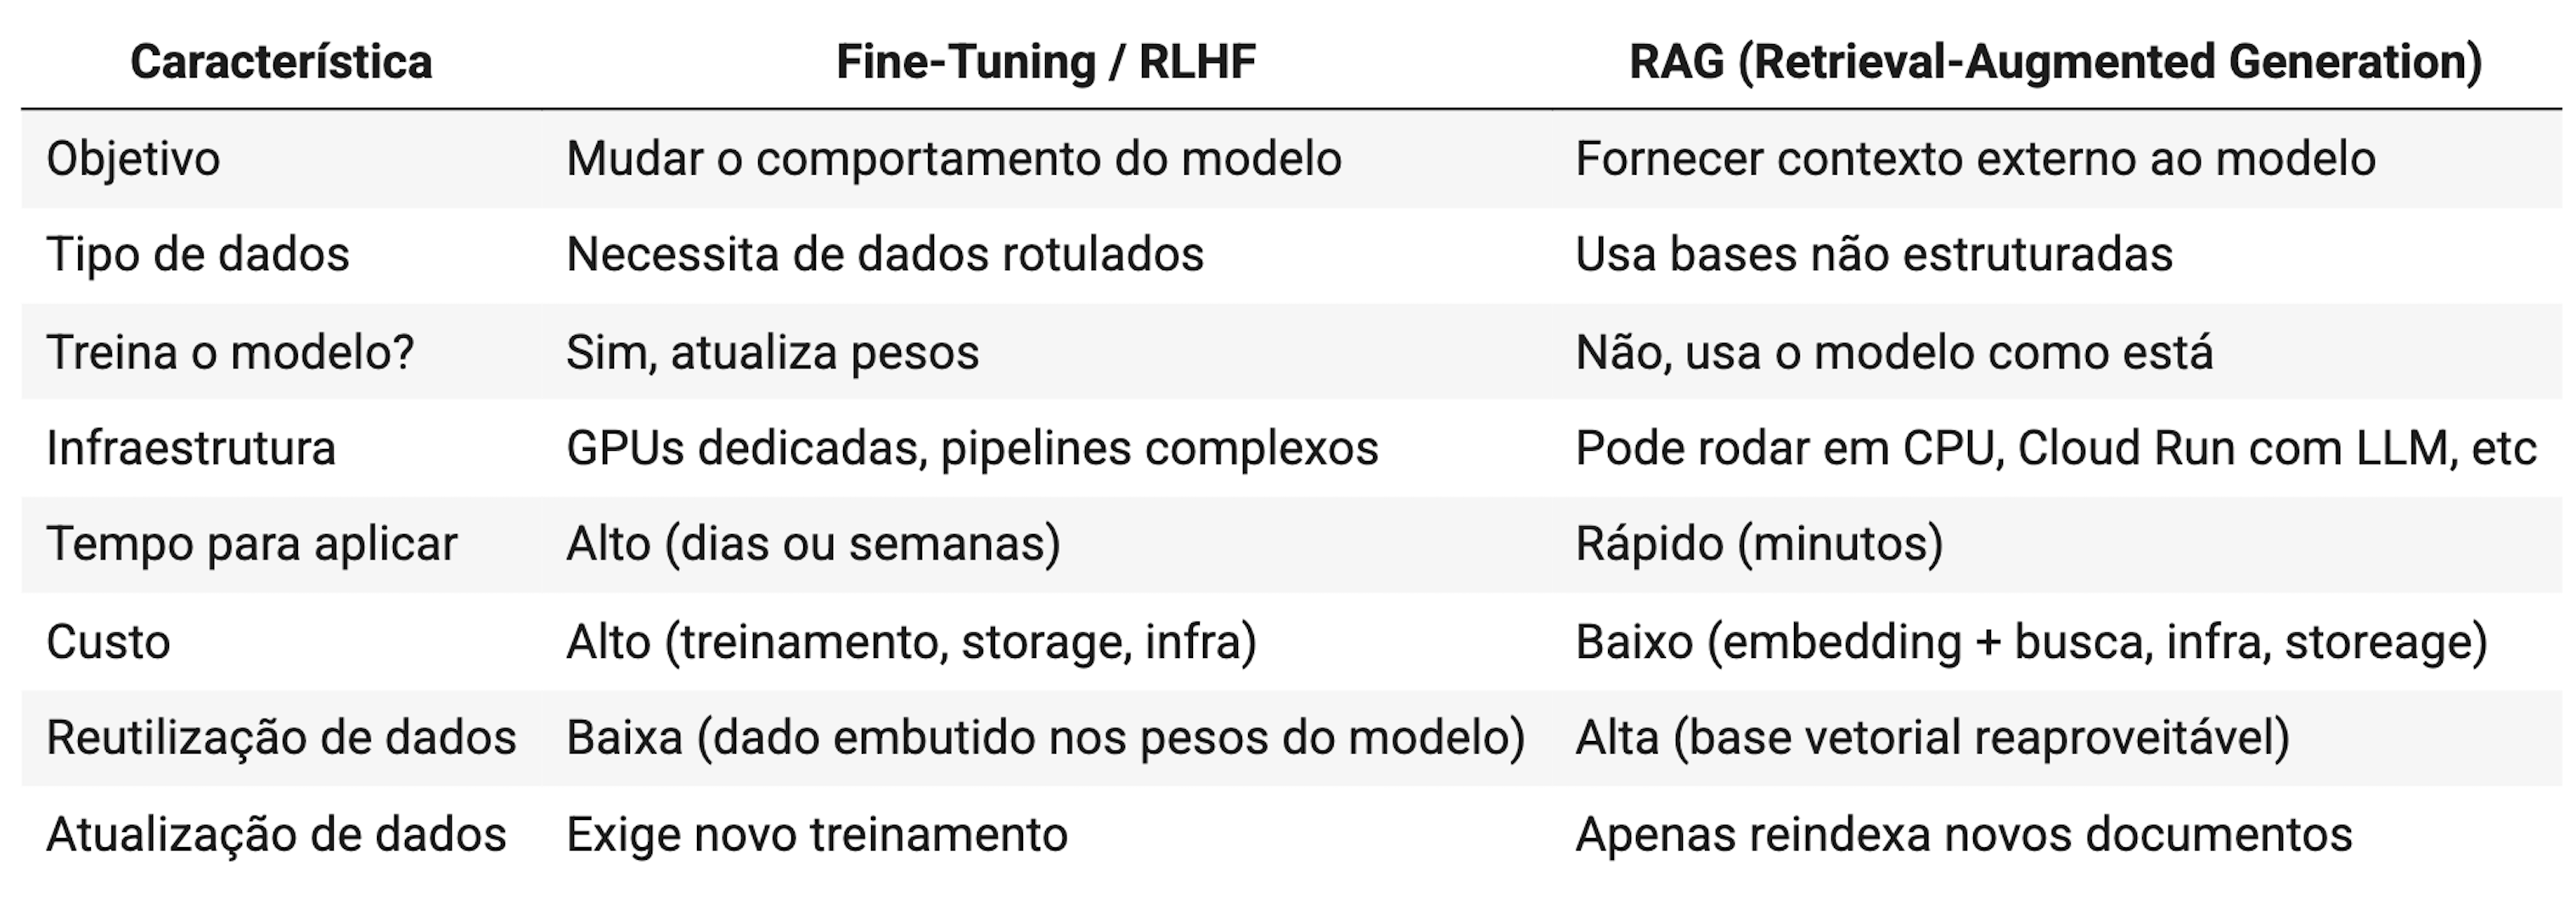

## Quando usar Fine-Tuning?

- Quando você **quer ensinar novas habilidades específicas** ao modelo.
- Quando não existe uma base externa clara que o modelo possa usar.
- Quando há **tempo, recurso e dados rotulados de qualidade**.



## Quando usar RAG?

- Quando o objetivo é **trazer informações atualizadas, externas ou privadas**.
- Quando **não se pode ou não se quer treinar o modelo**.
- Quando o foco é **responder com base em documentos reais**.

## Neste projeto, usamos RAG porque ele é:

* Simples de implementar  
* Eficiente com documentos dinâmicos  
* Eficaz para gerar respostas baseadas em **notícias reais**

## 10. Conclusão

Neste notebook, exploramos passo a passo como funciona um sistema completo de **IA generativa com RAG** (Retrieval-Augmented Generation), aplicando tudo a um **cenário real com notícias jornalísticas**.

Repassamos como:

- **Coletar e preparar os dados**:
  - Scraping
  - Divisão em chunks
- **Gerar embeddings vetoriais semânticos com HuggingFace**:
  - Modelo: sentence-transformers/all-MiniLM-L6-v2
  - Dimensão: 384 vetores
- **Utilizar banco vetorial para:**
  - Provisionamento em cloud
  - Indexação dos dados
- **Provisionar o LLama no Cloud Run:**
  - Buscar contexto relevante em nosso banco vetorial, com base em uma pergunta do usuário
  - Gerar uma resposta fundamentada com LLaMA via Ollama


### O que explorar a seguir?

- Indexar outras fontes (PDFs, bancos SQL/NoSQL, documentos internos, etc)
- **Incluir feedback do usuário para melhorar recomendações**.
  - Será que temos uma melhora se adicionar um joinha e/ou um desike na resposta do chatbot, via frontend, como feedback do usuário, para penalizar ou melhorar o rankeamento de alguns vetores no banco vetorial? Fica o desafio!
- Testar outros modelos no Ollama (Mistral, Phi, Codellama, Deepseek, etc)

# Extra: Diagrama da estrutura do projeto no VsCode

- GitHub: https://github.com/will3g/RAG-Private-LLM-at-Cloud-Run/tree/master

## Diagrama da pipeline de ingestão de dados

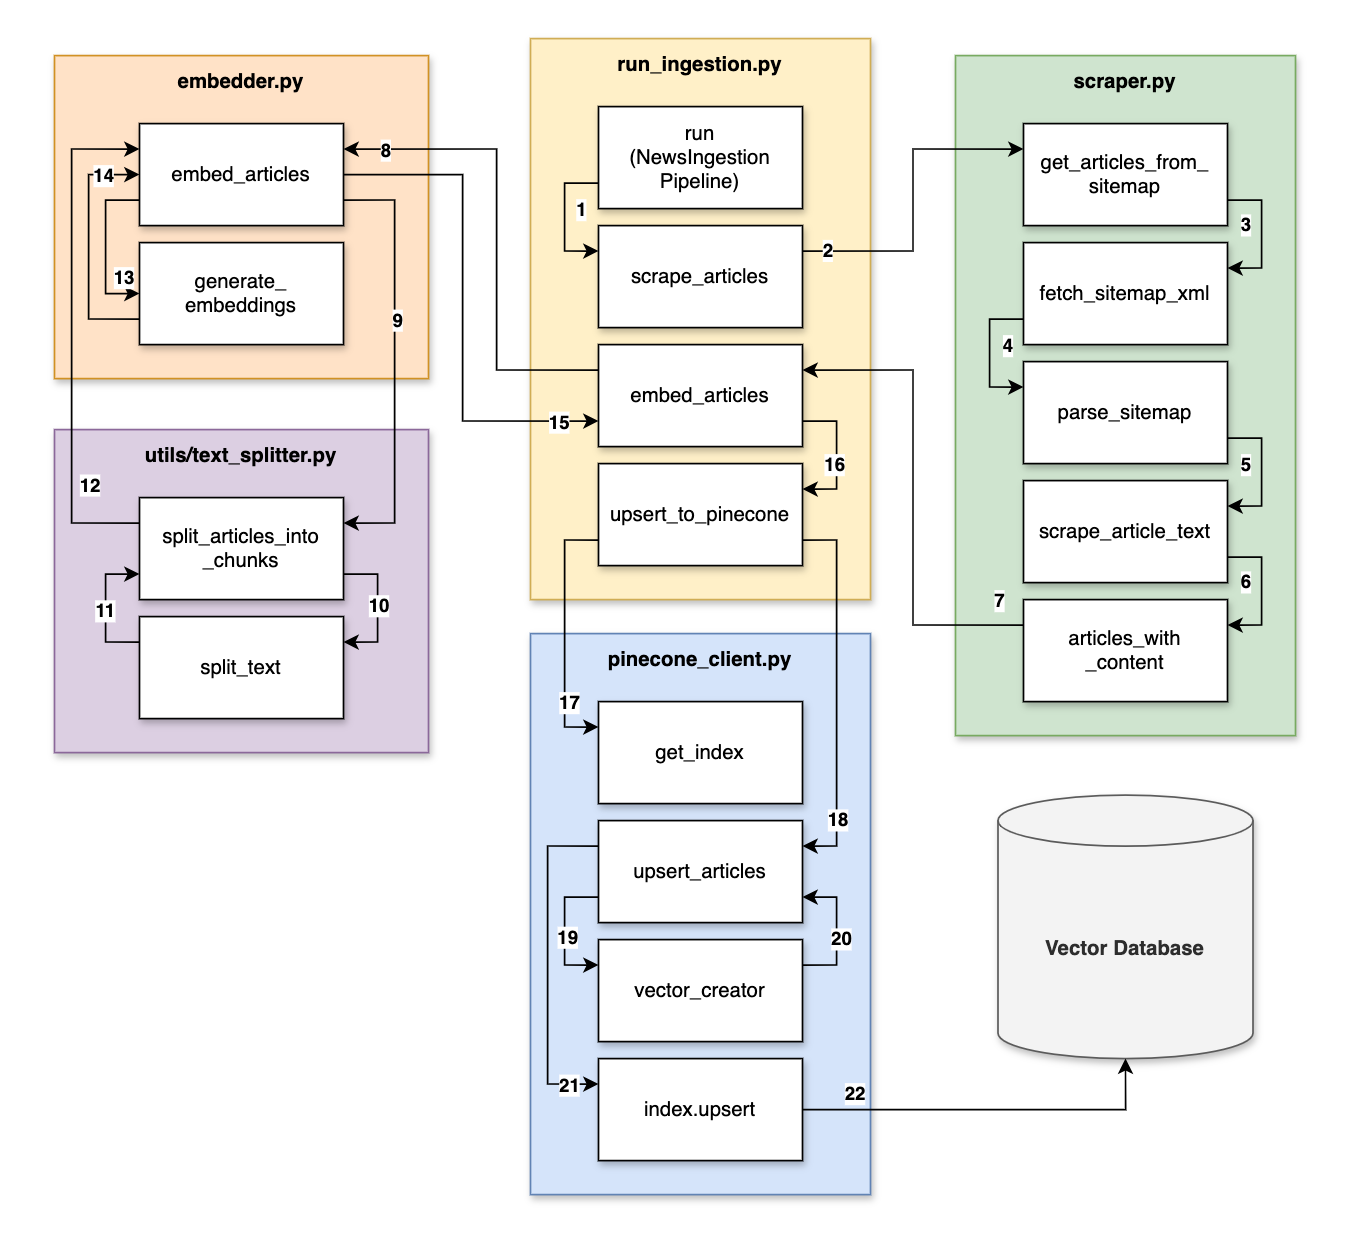

## Diagrama da interação do usuário com a LLM + Banco Vetorial

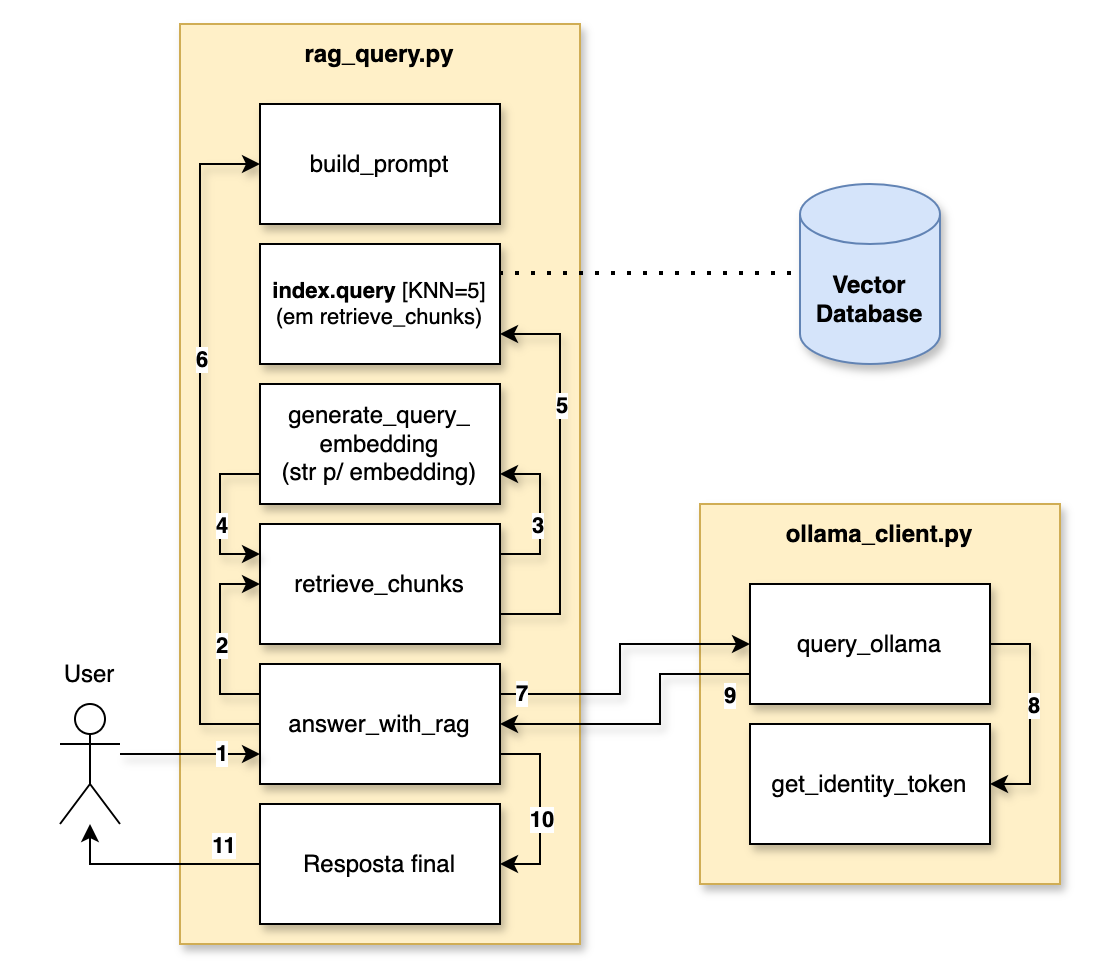